# Parte 4: Clasificación con CNN

### A VER, yo lo que haría es coger y para las redes neuronales en el preprocesamiento no las convertiría a un solo array si no que lo dejaría como una matriz separada con cada fila para cada electrón o algo así, esto es un poco raro pero así podemos mantener la propiedad espacial para que se tenga en cuenta por la LSTM, la CNN, y la CapsNet

Resultados:

    loss       accuracy     val_loss    val_accuracy
    0.148178	0.985302	2.696184	0.659483
    
Por tanto: 

    E = 1 - Accuracy
    Etrain = 1 - 0.985302 = 0.014698
    Etest = 1 - 0.659483 = 0.340517
    
    Bias = Etrain - Ehuman = 0.014698
    Variance = Etest - Etrain = 0.325819

Observamos que el bias es bajo pero la varianza es alta (33%), es decir, no generaliza bien. Por tanto, vamos a probar cambiando la arquitectura, regularizando...

### 1 - Import Libraries

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


### 2 - Load data

In [2]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [3]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    #mdata = mat['output']
    #val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(mat["task"]), np.array(mat["data"]))
    return output

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
user = '0091' # SE PUEDE CAMBIAR

lTaskData = []
for i_rec in range(1,total_records+1):
        record = "userS"+user+"f"+str(i_rec)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x
        
        if task3 != "":
            outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
        else: 
            outT = (output.task == task1) | (output.task == task2)
        outData = output.data[outT[:,0],0:np.shape(output.data)[1]]
        
        outTask = output.task[outT[:,0]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)

# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev = [],[],[],[] 
for j in range(0,total_records-2): # Cogemos 2 registros para entrenamiento
    X_train.extend(lTaskData[j].data)
    y_train.extend(lTaskData[j].task)
    
X_dev.extend(lTaskData[total_records-2].data) # Cogemos un registro para el dev set
y_dev.extend(lTaskData[total_records-2].task)

X_train = np.array(X_train)
y_train = np.ravel(np.array(y_train))
X_dev = np.array(X_dev)
y_dev = np.ravel(np.array(y_dev))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_one_hot = np.concatenate((y_train, y_dev), axis=0)
y_one_hot = encoder.fit_transform (y_one_hot.reshape(-1,1))
y_train = y_one_hot[:np.shape(y_train)[0]]
y_dev = y_one_hot[np.shape(y_train)[0]:]

print("ONE HOT ENCODER:")
print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)

print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)


X_test, y_test = [],[]
X_test.extend(lTaskData[total_records-1].data) # Cogemos un registro para el test set
y_test.extend(lTaskData[total_records-1].task)


X_test = np.array(X_test)
y_test = np.ravel(np.array(y_test))
print()
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)

# ONE HOT ENCODER
encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

print("ONE HOT ENCODER:")
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)
    

X_train: (1837, 96)
y_train: (1837,)
X_dev: (928, 96)
y_dev: (928,)
ONE HOT ENCODER:
X_train: (1837, 96)
y_train: (1837, 3)
X_dev: (928, 96)
y_dev: (928, 3)

X_test: (908, 96)
y_test: (908,)
ONE HOT ENCODER:
X_test: (908, 96)
y_test: (908, 3)


### 3. Initialize variables

In [5]:
INPUTS = X_train.shape[1]
OUTPUTS = y_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

Some data is displayed to test correctness:

In [6]:
X_train[:2]

array([[0.04408895, 0.12253977, 0.04091295, 0.08794782, 0.15217319,
        0.13608194, 0.2390196 , 0.13782482, 0.09390321, 0.04168143,
        0.01182343, 0.06681896, 0.22746509, 0.19109141, 0.12382088,
        0.16280571, 0.18183189, 0.03489224, 0.08915041, 0.25065591,
        0.05125344, 0.00878363, 0.06399049, 0.01269724, 0.37617251,
        0.75052793, 1.22515657, 0.34716337, 0.57574146, 0.22845317,
        0.29124432, 1.55810067, 0.17399072, 0.23187383, 0.09419699,
        0.06491878, 0.21030758, 0.11561159, 0.00684065, 0.05363316,
        0.14742724, 0.20516924, 0.16582891, 0.39129693, 0.01763402,
        0.05230747, 0.08436656, 0.05071257, 0.56726584, 0.21727165,
        0.5006733 , 0.09225466, 0.35750867, 0.43229655, 0.32666971,
        1.18042048, 0.04529925, 0.07339755, 0.12920241, 0.0228346 ,
        0.65176526, 0.09837585, 0.10240039, 0.35185881, 0.26348807,
        1.00112018, 0.61259061, 0.26154294, 0.2272173 , 0.11858029,
        0.23408875, 0.139735  , 0.43931357, 0.19

In [7]:
X_dev[:2]

array([[0.31977337, 0.34138627, 0.05036713, 0.01260456, 0.0353549 ,
        0.1185597 , 0.0467738 , 0.02048903, 0.11750225, 0.18469527,
        0.07158117, 0.04380819, 0.12918097, 0.15723066, 0.02486799,
        0.03569243, 0.13103253, 0.06666701, 0.12041935, 0.114042  ,
        0.01127984, 0.00650994, 0.05578655, 0.03110349, 1.27905692,
        0.72867136, 0.16631234, 0.39783501, 0.3504427 , 0.14931918,
        0.27219299, 0.119918  , 0.26639091, 0.05500265, 0.22028407,
        0.02976071, 0.49903653, 0.47147668, 0.21772425, 0.09625628,
        0.07949809, 0.07850754, 0.11222314, 0.0312656 , 0.0638701 ,
        0.01024857, 0.20098298, 0.12413927, 0.7959434 , 0.33244281,
        0.10382577, 0.36052956, 0.10868066, 0.25468323, 0.25108932,
        0.10744763, 0.22111074, 0.06949752, 0.22837273, 0.09663771,
        2.78278246, 0.95993224, 0.68951591, 0.5680906 , 0.29189192,
        0.02141107, 0.20762499, 0.11463274, 0.26281785, 0.02967406,
        0.25185108, 0.18281109, 1.13036793, 0.22

In [8]:
y_train[:2]

array([[0., 0., 1.],
       [0., 0., 1.]])

In [9]:
y_dev[:2]

array([[0., 1., 0.],
       [0., 1., 0.]])

In [10]:
X_dev[0].shape

(96,)

In [11]:
X_dev.shape

(928, 96)

In [12]:
X_train.shape

(1837, 96)

In [21]:
# Change X to a matrix: 

electrodes_name = ["C3", "Cz", "C4", "CP1", "CP2", "P3", "Pz", "P4"]

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)
print()

X_train_new = []
for x in X_train: 
    X_train_new.append(x.reshape(len(electrodes_name), int(len(X_train[0])/len(electrodes_name)) )) ## Quiero hacer un miarray.reshape(numfilas, numcolumnas) en este caso numfilas = len(electrodes_name)
    # y numcolumnas = int(len(X_dev[0])/len(electrodes_name))
    # Asi puedo usarlo todo con distribución espacial :-) 
    
"""
for x in X_train_new: 
    print(np.shape(x))
    print(x)
"""
X_train_new = np.asarray(X_train_new)
X_train = X_train_new

X_dev_new = []
for x in X_dev: 
    X_dev_new.append(x.reshape(len(electrodes_name), int(len(X_dev[0])/len(electrodes_name)) )) 
X_dev_new = np.asarray(X_dev_new)
X_dev = X_dev_new

X_test_new = []
for x in X_test: 
    X_test_new.append(x.reshape(len(electrodes_name), int(len(X_test[0])/len(electrodes_name)) ))
X_test_new = np.asarray(X_test_new)
X_test = X_test_new


print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(1837, 96)
(928, 96)
(908, 96)

(1837, 8, 12)
(928, 8, 12)
(908, 8, 12)


In [24]:
X_train

array([[[4.40889459e-02, 1.22539767e-01, 4.09129528e-02, ...,
         4.16814331e-02, 1.18234270e-02, 6.68189584e-02],
        [2.27465092e-01, 1.91091408e-01, 1.23820880e-01, ...,
         8.78363164e-03, 6.39904876e-02, 1.26972450e-02],
        [3.76172510e-01, 7.50527927e-01, 1.22515657e+00, ...,
         2.31873828e-01, 9.41969885e-02, 6.49187838e-02],
        ...,
        [6.51765257e-01, 9.83758470e-02, 1.02400394e-01, ...,
         1.18580288e-01, 2.34088748e-01, 1.39735002e-01],
        [4.39313566e-01, 1.96065341e-01, 3.42330098e-01, ...,
         1.06671951e-01, 3.81912471e-01, 2.21350975e-02],
        [1.05885478e+00, 2.57300974e-01, 1.17149903e+00, ...,
         2.17100488e-01, 2.60473680e-01, 7.63339134e-03]],

       [[2.56143852e-01, 1.14343039e-01, 9.70476313e-02, ...,
         3.42833147e-02, 7.15881221e-02, 7.20334729e-02],
        [2.23752320e-01, 3.64864219e-01, 1.75762187e-01, ...,
         8.60680130e-02, 5.99468668e-02, 4.96307733e-03],
        [6.89814682e-01, 

In [22]:
print(X_train.shape[0], X_train.shape[1], X_train.shape[2])

1837 8 12


In [25]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1)
X_dev = X_dev.reshape(X_dev.shape[0], X_dev.shape[1], X_dev.shape[2],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

# INPUT SHAPE: batch_size (número de muestras que vamos a mostrar a la red neuronal), height (alto de la imagen o 
# num filas del array de datos), width (ancho de la imagen o num de columnas del array de datos, depth (profundidad del 
# array o num canales de la imagen) 

(1837, 8, 12, 1)
(928, 8, 12, 1)
(908, 8, 12, 1)


### 4 - Set hyperparameters

In [26]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [ ]:
"""
n_epochs = 100 #2000
#learning_rate = 0.001
batch_size = 32 #250 
n_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers
rate_dropout = [0.8, 0.4, 0.2, 0.1]
weight_decay = 1e-4
"""

### 5 - Build the model: 

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers, regularizers
import keras.backend as K
#K.set_image_data_format('channels_first')

weight_decay = 1e-4

model = Sequential()
# Convolution2D(filtrosConv1, tamaño_filtro1, padding="same", input_shape=(longitud, altura,3), activation = "relu")
    # - filtrosConv1 número de filtros que aplicaremos tras la primera convolución, normalmente este tamaño va a aumentando
    # tras convoluciones para que aumente la dimensión de profundidad (qué cosas hay en mi imagen)
    # - tamaño_filtro1 tamaño espacial del kernel (de los filtros)
    # - padding = si es same es que es igual que la imagen, vamos crea una imagen del mismo tamaño con el filtro, si es 
    # valid es que no hay padding y crea una imagen más pequeña que la imagen (creo)
    # - input_shape = longitud y altura, tamaño que usará para convolucionar al entrenar
model.add(Conv2D(48, kernel_size=(3, 3), padding="same", activation="relu",input_shape=(8, 12,1), kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(48, kernel_size=(3, 3), padding="same", activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(y_train.shape[1], activation="softmax"))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)        
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 12, 48)         480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 12, 48)         20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 48)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 6, 96)          41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 6, 96)          83040     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 3, 96)         

In [28]:
model.layers

In [29]:
for l in model.layers: print (l.name)

conv2d
conv2d_1
max_pooling2d_1
dropout_2
conv2d_2
conv2d_3
max_pooling2d_2
dropout_3
conv2d_4
conv2d_5
max_pooling2d_3
dropout_4
flatten
dense


All the parameters of a layer can bee accessed:

In [30]:
weights, biases = model.layers[0].get_weights()
weights.shape

(3, 3, 1, 48)

In [31]:
weights

array([[[[ 0.18378897,  0.00765834, -0.37459016,  0.23160213,
          -0.33648065, -0.5781717 ,  0.36913887,  0.16875818,
           0.06324659, -0.60873336,  0.5001523 ,  0.2160179 ,
          -0.7448615 , -0.11796068,  0.11014009,  0.0820864 ,
           0.6197849 , -0.12056042, -0.31946227, -0.40969467,
           0.3188121 , -0.71440935, -0.00898832, -0.31354707,
           0.20973665, -0.3141038 ,  0.7311095 , -0.64164597,
           0.9291396 , -0.46207115, -0.5100515 , -0.17804714,
           0.23417781, -0.0361379 ,  0.23483144, -0.6806582 ,
          -0.23889074, -0.8592226 ,  0.51059353,  0.43975976,
           0.5486252 ,  0.4413722 ,  0.2598966 ,  0.88314   ,
          -0.05115884,  0.04508558,  0.8006182 ,  0.04013082]],

        [[ 0.74249476, -0.5293907 , -0.25804833, -0.7443357 ,
          -0.3733877 , -0.49314386, -0.5952116 ,  0.51941025,
          -0.3931617 , -0.15890422,  0.18180543,  0.42089158,
           0.0261323 , -0.07050248,  0.6291971 , -0.09612551,
     

In [32]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [33]:
biases.shape

(48,)

### 6. Compile the model

### 7. Train the model with M-BGD

In [34]:
import time
start = time.time()
#history = model.fit(X_train, y_train, batch_size=32, steps_per_epoch=len(y_train)/32, epochs=100, verbose=2, validation_data=(X_dev, y_dev),callbacks=[tensorboard])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_dev, y_dev))
print (time.time() - start)



Epoch 1/100
58/58 - 2s - loss: 1.2456 - accuracy: 0.5014 - val_loss: 1.3538 - val_accuracy: 0.5442
Epoch 2/100
58/58 - 1s - loss: 0.9648 - accuracy: 0.6184 - val_loss: 1.0869 - val_accuracy: 0.6358
Epoch 3/100
58/58 - 1s - loss: 0.9210 - accuracy: 0.6369 - val_loss: 0.8969 - val_accuracy: 0.6918
Epoch 4/100
58/58 - 1s - loss: 0.8604 - accuracy: 0.6821 - val_loss: 1.0725 - val_accuracy: 0.6649
Epoch 5/100
58/58 - 1s - loss: 0.8480 - accuracy: 0.6957 - val_loss: 0.9296 - val_accuracy: 0.7188
Epoch 6/100
58/58 - 1s - loss: 0.7796 - accuracy: 0.7093 - val_loss: 1.0379 - val_accuracy: 0.6713
Epoch 7/100
58/58 - 1s - loss: 0.7375 - accuracy: 0.7322 - val_loss: 1.1137 - val_accuracy: 0.7047
Epoch 8/100
58/58 - 1s - loss: 0.7178 - accuracy: 0.7545 - val_loss: 0.9368 - val_accuracy: 0.7241
Epoch 9/100
58/58 - 1s - loss: 0.6421 - accuracy: 0.7855 - val_loss: 1.6416 - val_accuracy: 0.6433
Epoch 10/100
58/58 - 1s - loss: 0.6478 - accuracy: 0.7779 - val_loss: 0.9824 - val_accuracy: 0.6929
Epoch 11/

58/58 - 2s - loss: 0.1404 - accuracy: 0.9869 - val_loss: 2.9929 - val_accuracy: 0.6735
Epoch 84/100
58/58 - 2s - loss: 0.1646 - accuracy: 0.9826 - val_loss: 2.8914 - val_accuracy: 0.6369
Epoch 85/100
58/58 - 1s - loss: 0.1340 - accuracy: 0.9897 - val_loss: 2.3849 - val_accuracy: 0.6401
Epoch 86/100
58/58 - 1s - loss: 0.1268 - accuracy: 0.9929 - val_loss: 3.1336 - val_accuracy: 0.6487
Epoch 87/100
58/58 - 1s - loss: 0.1465 - accuracy: 0.9864 - val_loss: 2.1865 - val_accuracy: 0.6724
Epoch 88/100
58/58 - 1s - loss: 0.1244 - accuracy: 0.9946 - val_loss: 2.5612 - val_accuracy: 0.6724
Epoch 89/100
58/58 - 1s - loss: 0.1298 - accuracy: 0.9929 - val_loss: 1.8363 - val_accuracy: 0.6983
Epoch 90/100
58/58 - 2s - loss: 0.1327 - accuracy: 0.9913 - val_loss: 2.3641 - val_accuracy: 0.6336
Epoch 91/100
58/58 - 2s - loss: 0.1231 - accuracy: 0.9946 - val_loss: 2.4206 - val_accuracy: 0.6853
Epoch 92/100
58/58 - 2s - loss: 0.1320 - accuracy: 0.9913 - val_loss: 2.2322 - val_accuracy: 0.6638
Epoch 93/100


### 8. Get the results

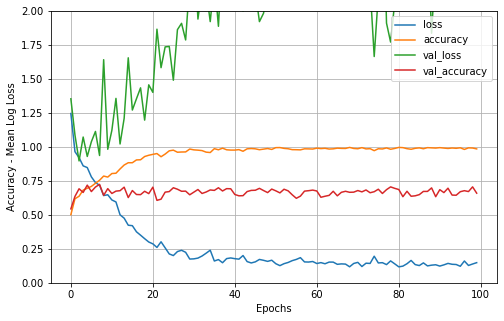

In [35]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [36]:
history.params

{'verbose': 2, 'epochs': 100, 'steps': 58}

In [37]:
results[-1:]

,loss,accuracy,val_loss,val_accuracy
99,0.148178,0.985302,2.696184,0.659483


In [38]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

AttributeError: 'DataFrame' object has no attribute 'categorical_accuracy'

In [27]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.6681034564971924


#### Let's see how the model predicts using the development test set:

In [28]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

array([[0.44, 0.51, 0.05],
       [0.06, 0.25, 0.69],
       [0.92, 0.02, 0.06],
       [0.2 , 0.61, 0.18],
       [0.07, 0.92, 0.01],
       [0.04, 0.54, 0.42],
       [0.04, 0.79, 0.17],
       [0.  , 0.8 , 0.2 ],
       [0.  , 0.09, 0.91],
       [0.  , 0.  , 1.  ],
       [0.  , 0.01, 0.99],
       [0.  , 0.37, 0.63],
       [0.09, 0.91, 0.01],
       [0.  , 0.99, 0.  ],
       [0.01, 0.97, 0.02],
       [0.01, 0.24, 0.76],
       [0.23, 0.76, 0.02],
       [0.  , 0.99, 0.01],
       [0.  , 1.  , 0.  ],
       [0.  , 0.99, 0.01]], dtype=float32)

In [29]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
y_dev[:20]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [31]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(y_dev,1))
print (dev_correct_predictions[:30])

[ True False False  True  True  True  True  True False False False False
  True  True  True False  True  True  True  True  True  True False  True
 False  True  True  True  True  True]


In [32]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({True: 620, False: 308})

### 9. Save model

We save the model if it is better than others 

In [30]:
# Save
model.save('./Modelos/EGG_prac1_ANN_model3.h5') # Change the name in each model

In [34]:
# Extract
"""
new_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(X_dev)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

"\nnew_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')\n\nimport numpy as np\n\n# Verify state\nnew_predictions = new_model.predict(X_dev)\nnp.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)\n\n# Note that the optimizer state is also preserved:\n# you can resume training where you left off.\n"

### 10 - Final Test

#### 10.1 - Load the final test set

In [35]:

"""
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
users = ["0091"] # SE PUEDE CAMBIAR
"""

In [36]:
"""
def readRegisterAndReturnXy(user, total_records, task1, task2, task3 = ""):
    lTaskData = []
    for i_rec in range(1,total_records+1):
            record = "userS"+user+"f"+str(i_rec)+".mat"
            output = read_outputs(record) # output.task será y, output.data será x

            if task3 != "":
                outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
            else: 
                outT = (output.task == task1) | (output.task == task2)
            outData = output.data[outT[:,0],0:np.shape(output.data)[1]]

            outTask = output.task[outT[:,0]]
            outTD = OutTaskData(outTask, outData)
            lTaskData.append(outTD)

    X_test, y_test = [],[]
    for j in range(0,total_records):
        X_test.extend(lTaskData[j].data)
        y_test.extend(lTaskData[j].task)

    X_test = np.array(X_test)
    y_test = np.ravel(np.array(y_test))

    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)

    # ONE HOT ENCODER
    encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
    y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

    print("ONE HOT ENCODER:")
    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)
    
    return X_test, y_test
"""

In [37]:
"""
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)


"""

'\nn_final_test = n_instances-n_train-n_dev\n\nx_final_test = attributes.values[n_train+n_dev:n_instances]\nt_final_test = label.values[n_train+n_dev:n_instances]\n\nprint ("x_test:",x_final_test.shape)\nprint ("t_test:",t_final_test.shape)\n\n\n'

#### 10.2 - Evaluate the model

In [37]:
from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success

In [38]:
users = ["0091"]
for u in users:   
    print("USER:", u)
    #X_test, y_test = readRegisterAndReturnXy(u, total_records, 122, 123, 127)
    accuracy, success = predictWithModel(model, X_test, y_test, 122, 123, 127)
    print(u, accuracy, success)
    print()

USER: 0091
29/29 [==============================] - 0s 1ms/step - loss: 1.5197 - categorical_accuracy: 0.6156
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]

[ True  True  True  True  True  True  True False False False  True  True
  True  True  True False  True  True  True  True  True  True False False
  True False False False  True  True  True  True  True  True  True  True
  True False False False  True  True  True False  True False False  True
  True False False False  True  True  True  True False False False False
  True  True  True  True  True  True  True False False  True  True False
 False False False  True  True  True  True False False False False False
 False False False  True False False  True False False  True False  True
  True  True  True  True False False False False  True  True Fal

In [40]:
#model.evaluate(x_final_test, t_final_test) # Un 77 es un accuracy bajo 

The outputs computed by the neural network for the final testing dataset.

In [41]:
"""
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]
"""

'\ntest_predictions=model.predict(x_final_test)\ntest_rounded_predictions=np.round(test_predictions)\nindices = np.argmax(test_predictions,1)\nfor row, index in zip(test_rounded_predictions, indices): row[index]=1\ntest_rounded_predictions[:20]\n'

The target outputs.

In [42]:
# t_final_test[:20]

The first 30 predictions. True means that the neural network correctly classifies the input vector.

In [43]:
# test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
# test_correct_predictions[:30]

#### The final test accuracy.

In [44]:
"""from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results"""

'from collections import Counter\nfinal_test_prediction_results=Counter(test_correct_predictions)\nfinal_test_prediction_results'

In [45]:
#final_test_prediction_results[True]/sum(final_test_prediction_results.values())